In [14]:
%matplotlib inline

from __future__ import print_function
from statsmodels.compat import lzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

from pandas.tseries.offsets import *

# Проблема данной задачи (решаем эластичность)

Расчитать эластичность можно с помощью Регрессионного анализаз (Price Elasticity of Demand Analysis (PED)).

В маркетинге, важно понимать, как изменение цены будет влиять на кол-во покупок. Данный анализ поможет ответить на вопрос:

1. “На сколько мы увеличим продажи, если снизим цену?”
2. “Если мы подними цену, то на какое количество штук у нас будет "просадка" в продажа?”

И т.п.

# Загрузка данных

In [15]:
beef = pd.read_csv('Price_demand.csv')
beef.head(5)

,Year,Quarter,Quantity,Price
0,1977,1,22.9976,142.1667
1,1977,2,22.6131,143.9333
2,1977,3,23.4054,146.5000
3,1977,4,22.7401,150.8000
4,1978,1,22.0441,160.0000


# Моделирование

### OLS

In [16]:
beef_model = ols("Quantity ~ Price", data=beef).fit()

In [17]:
print(beef_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     811.2
Date:                Thu, 30 Sep 2021   Prob (F-statistic):           1.69e-46
Time:                        20:15:29   Log-Likelihood:                -77.493
No. Observations:                  91   AIC:                             159.0
Df Residuals:                      89   BIC:                             164.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.0515      0.413     72.701      0.0

Результат:

- малый P values, означает, что H0 может быть отклонена и Price не влияет на Quantity

- большой R2 говорит о том, что модель хорошо объясняет целевую переменную

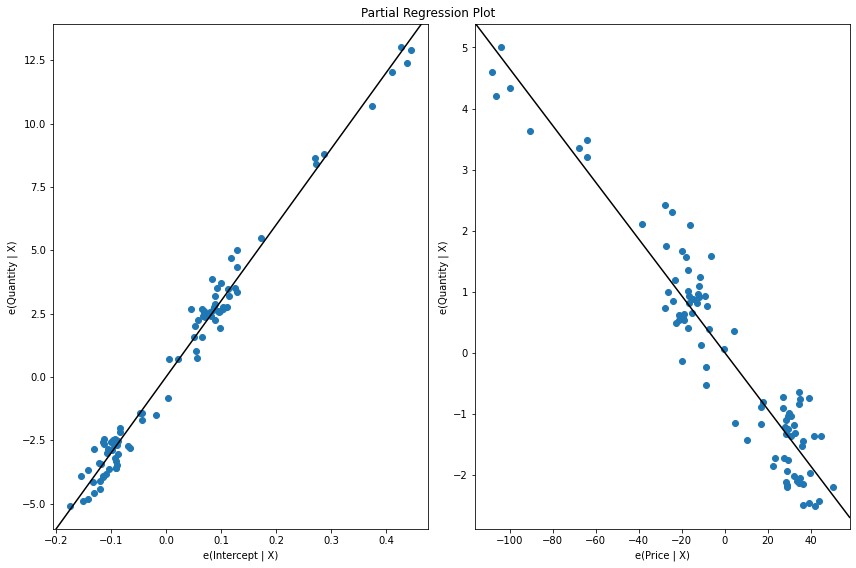

In [18]:
# визуализируем распределение
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(beef_model, fig=fig)

Тренд показывает, что Price все же имеет отклик в Quantity. Но мы видим увеличение разброса при увеличении цены.

### Component-Component plus Residual (CCPR) визуализация

CCPR визуализация дает возможность увидеть эффект объяснения регрессией переменных и найти не объяснимый эффект.

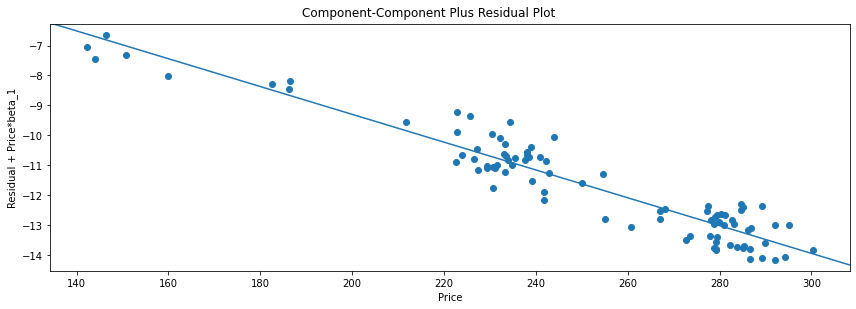

In [19]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(beef_model, fig=fig)

Мы видим отношение между Quantity и Price, они явно линейные. Ошибок-выбрасов мало.

### Regression визуализация

Проверка взаимодействия переменных с Price

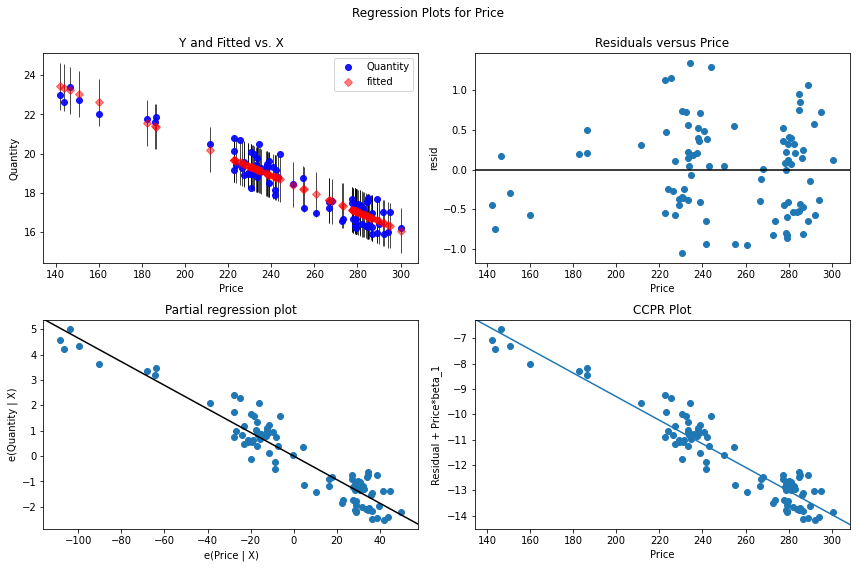

In [20]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(beef_model, 'Price', fig=fig)

### Recursive Least Square (RLS)

Применим (RLS) в качестве исследования ппостоянства параметров

P.S. для работы с RLS нужно добавить в качестве индекса - время

In [21]:
beef['Year'] = pd.to_datetime(beef['Year'], format="%Y")
beef.head(5)

,Year,Quarter,Quantity,Price
0,1977-01-01,1,22.9976,142.1667
1,1977-01-01,2,22.6131,143.9333
2,1977-01-01,3,23.4054,146.5000
3,1977-01-01,4,22.7401,150.8000
4,1978-01-01,1,22.0441,160.0000


In [22]:
beef['Date'] = beef.apply(lambda x:(x['Year'] + BQuarterBegin(x['Quarter'])), axis=1)
beef.drop(['Year', 'Quarter'], axis=1, inplace=True)
beef.set_index('Date', inplace=True)
beef.head(10)

,Quantity,Price
Date,,
1977-03-01,22.9976,142.1667
1977-06-01,22.6131,143.9333
1977-09-01,23.4054,146.5000
1977-12-01,22.7401,150.8000
1978-03-01,22.0441,160.0000
1978-06-01,21.7602,182.5333
1978-09-01,21.6064,186.2000
1978-12-01,21.8814,186.4333
1979-03-01,20.5086,211.7000


In [23]:
endog = beef['Quantity']

# создаем доп.переменную в виде константного значения
exog = sm.add_constant(beef['Price'])

### RLS оценка

In [24]:
mod = sm.RecursiveLS(endog, exog)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:               Quantity   No. Observations:                   91
Model:                    RecursiveLS   Log Likelihood                 -86.733
Date:                Thu, 30 Sep 2021   R-squared:                       0.901
Time:                        20:19:47   AIC                            177.467
Sample:                    03-01-1977   BIC                            182.488
                         - 09-01-1999   HQIC                           179.493
Covariance Type:            nonrobust   Scale                            0.329
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0515      0.413     72.701      0.000      29.241      30.862
Price         -0.0465      0.002    -28.482      0.000      -0.050      -0.043
Ljung-Box (L1) (Q):                   3.94   Jarque-

C:\Users\ArtSe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency BQS-DEC will be used.
  warnings.warn('No frequency information was'


RLS оценивает рекурсивно, поэтому оценок столько, сколько данных, в сводной таблице представлены только параметры регрессии, оцененные по всей выборке; эти оценки эквивалентны оценкам МНК.

### RLS визуализация

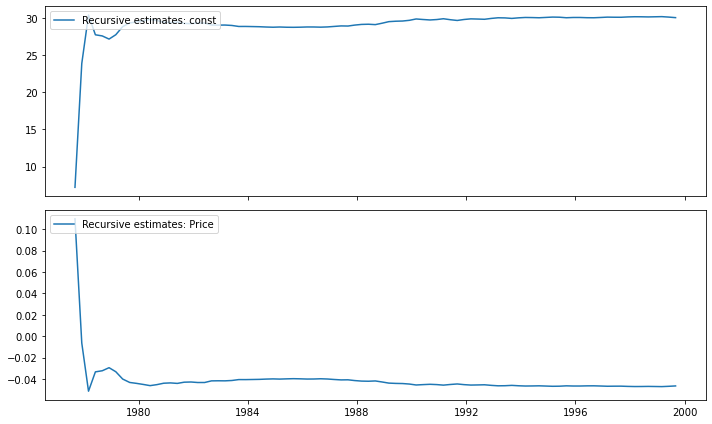

In [25]:
res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(10,6));

+ стабильность параметров

In [ ]:
fig = res.plot_cusum(figsize=(10,6));

На приведенном выше графике статистика CUSUM не выходит за пределы 5%-ных диапазонов значимости, поэтому мы не можем отвергнуть нулевую гипотезу о стабильных параметрах.

# Заключение

Мы проверили, гипотезу о том, насколько чувствительны покупатели к изменению цены продукта.

Мы выяснили, что эластичность количества товара, к изменению его цены, может быть применена тогда, когда ничего, кроме цены, не меняется.